In [1]:
import pandas as pd
from wfield import *
import pickle
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from NatMovie_utils import *


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import cupy as cp

In [3]:
path_wfield = r'/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/natural-movie/process/20240708-175712-wfield'

experiment = os.path.basename(path_wfield)[:15]
mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
path_out = pjoin(path_wfield, '..', experiment + '-natural-movie')
os.makedirs(path_out, exist_ok=True)
print(experiment,mouse)
trialfile = pd.read_csv(pjoin(path_wfield, 'trials.csv'), header=None).values.astype(int)
rawPath = pjoin(path_wfield, '../../raw')
movie_folder = pjoin(rawPath, 'natural_movies')
movie_list = pd.read_csv(pjoin(movie_folder, 'movie_list.txt'), header=None).values
n_movie = movie_list.size
movie_name_list = []
for imovie in range(n_movie):
    movie_name_list.append(str(movie_list[imovie])[2:-6])

n_frame = 150  # 帧
pre_length = 20
after_lenth = 30
whole_length = trialfile[-1, 2]+50


20240708-175712 Q20


In [4]:
frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')

if os.path.exists(pjoin(path_out, 'tif_sort.npy')):
    print('loading tif_sort.npy')
    tif_sort=cp.load(pjoin(path_out, 'tif_sort.npy'))
    print('tiff_sort.shape: (height, width, n_frame, n_movie, n_rep) ', tif_sort.shape)
    tif_height,tif_width = tif_sort.shape[:2]
    n_rep = tif_sort.shape[-1]

else:
    tif = mmap_dat(glob(pjoin(path_wfield, "*.bin"))[0])
    tif470 = (tif[:,0]-frames_average[0])/frames_average[0]
    tif405 = (tif[:,1]-frames_average[1])/frames_average[1]
    tif_corr=tif470-tif405
    print('finish tif_corr')
    tif_height,tif_width=tif_corr.shape[1:]


    # tif_corr1=cp.asarray(tif_corr[:whole_length])
    # tif_sort2 = Gsorting_NatMov(tif_corr1.reshape(-1,tif_height*tif_width).T, trialfile[:, 1], n_movie, n_frame, pre_length, after_lenth).astype('float32')
    # tif_sort1 = tif_sort2.reshape(tif_height,tif_width,*tif_sort2.shape[1:])
    # tif_sort=cp.asnumpy(tif_sort1)
    # del tif_sort1, tif_sort2, tif_corr1
    tif_sort = sorting_NatMov(tif_corr.reshape(-1,tif_height*tif_width).T, trialfile[:, 1], n_movie, n_frame, pre_length, after_lenth).astype('float32')
    tif_sort = tif_sort.reshape(tif_height,tif_width,*tif_sort.shape[1:])
    n_rep = tif_sort.shape[-1]
    print('tif_sort.shape: (height, width, n_frame, n_movie, n_rep) ', tif_sort.shape)
    np.save(pjoin(path_out, 'tif_sort.npy'), tif_sort)
    print('finish save tif_sort.npy')

loading tif_sort.npy
tiff_sort.shape: (height, width, n_frame, n_movie, n_rep)  (512, 512, 200, 14, 5)


In [5]:
# load CCF

from wfield import *

lmarks = load_allen_landmarks(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'))
ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
# this loads the untransformed atlas
atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'),
                                                            do_transform=True)
# this converts the reference to image space (unwarped)
ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                         resolution=lmarks['resolution'],
                                         bregma_offset=lmarks['bregma_offset'])


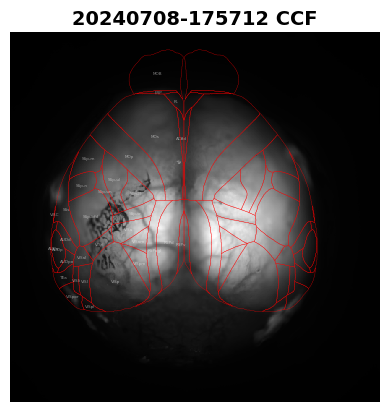

In [6]:
# plot avg_frame & CCF

fig = plt.figure()
plt.imshow(frames_average[0], cmap='gray')
for i, r in ccf_regions_im.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')

plt.axis('off')
plt.title(experiment+' CCF')
fig.set_facecolor('white')
plt.show()


In [142]:
# lmarks['transform']

# from skimage.transform import SimilarityTransform

# lmarks_transform = SimilarityTransform(matrix=np.array([[ 6.93028420e-01, 6.73982127e-04, 1.85572216e+01], 
#                                                         [-6.73982127e-04, 6.93028420e-01, 2.13194231e+01], 
#                                                         [0, 0, 1]]))

In [136]:
from skimage.transform import warp

avg_warped1 = tif_sort[:,:,:,0,0]
# avg_warped1 = (avg_warped1 - avg_warped1.min()) / (avg_warped1.max() - avg_warped1.min())
avg_warped1[:,0,:] = 1e-10
avg_warped1[0,:,:] = 1e-10
avg_warped1[-1,:,:] = 1e-10
avg_warped1[:,-1,:] = 1e-10

avg_warped = cp.asnumpy(avg_warped1)
del avg_warped1
cp._default_memory_pool.free_all_blocks()

avg_warped2 = warp(np.asarray(avg_warped.transpose([2,0,1])),lmarks['transform'],
                order = 1, mode='constant', cval = 0, clip=True, preserve_range=True, output_shape=(540, 600)).transpose([1,2,0])
avg_warped3 = warp(np.asarray(avg_warped.transpose([2,1,0])),lmarks['transform'],
                order = 1, mode='constant', cval = 0, clip=True, preserve_range=True, output_shape=(540, 600)).transpose([2,1,0])
avg_warped4 = warp(np.asarray(avg_warped),lmarks['transform'],
                order = 1, mode='constant', cval = 0, clip=True, preserve_range=True, output_shape=(540, 600))




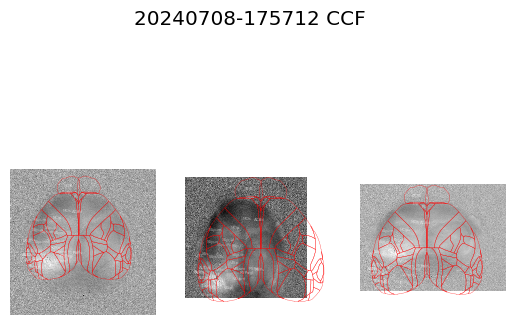

-0.73002946 0.7766967 -0.28010184 0.403092


In [144]:
# plot avg_frame & CCF

ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

fig, ax = plt.subplots(1, 4)
ax[0].imshow(avg_warped[:,:,50], cmap='gray')
for i, r in ccf_regions_im.iterrows():
    ax[0].plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    ax[0].plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    ax[0].text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')
    ax[0].axis('off')

ax[1].imshow(avg_warped2[:,:,40], cmap='gray')
for i, r in ccf_regions.iterrows():
    ax[1].plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    ax[1].plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    ax[1].text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')
    ax[1].axis('off')

ax[2].imshow(avg_warped3[:,:,40], cmap='gray')
for i, r in ccf_regions.iterrows():
    ax[2].plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    ax[2].plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    ax[2].text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')
    ax[2].axis('off')

ax[3].imshow(avg_warped4[:,:,40], cmap='gray')
for i, r in ccf_regions.iterrows():
    ax[3].plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    ax[3].plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    ax[3].text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')
    ax[3].axis('off')

plt.suptitle(experiment+' CCF')
fig.set_facecolor('white')
plt.show()

print(avg_warped.min(),avg_warped.max(),avg_warped2.min(),avg_warped2.max())

<Figure size 2000x1000 with 0 Axes>

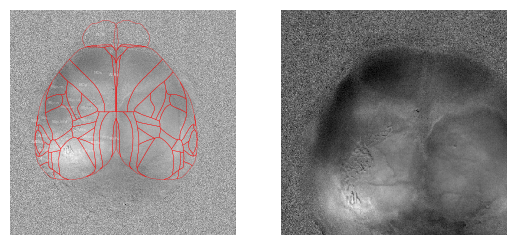

In [141]:
# test=cp.asnumpy(tif_sort[:,:,:,0,0])
# stack = SVDStack(test,np.eye(test.shape[-1]))
# stack.set_warped(1, M = lmarks['transform'])

# fig = plt.figure(figsize = [20,10])

# fig, ax = plt.subplots(1, 2)
# ax[0].imshow(stack.originalU[:,:,50], cmap='gray')
# for i, r in ccf_regions_im.iterrows():
#     ax[0].plot(r['left_x'], r['left_y'], 'r', lw=0.2)
#     ax[0].plot(r['right_x'], r['right_y'], 'r', lw=0.2)
#     ax[0].text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')
# ax[0].axis('off')

# ax[1].imshow(stack.U_warped[:,:,50], cmap='gray')
# for i, r in ccf_regions.iterrows():
#     ax[1].plot(r['left_x'], r['left_y'], 'r', lw=0.2)
#     ax[1].plot(r['right_x'], r['right_y'], 'r', lw=0.2)
#     ax[1].text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')
# ax[1].axis('off')

# plt.show()

In [7]:
def flat_mask(Uflat,xy):
    # index are in xy, like what np.where(mask) returns
    x = np.array(np.clip(xy[0],0,tif_height-1),dtype=int)
    y = np.array(np.clip(xy[1],0,tif_width-1),dtype=int)
    idx = np.ravel_multi_index((x,y),(tif_height,tif_width))
    t = Uflat[idx,:]
    return t

tif_sort_flat= cp.asnumpy(tif_sort.reshape(tif_height*tif_width,-1))
all_area_timecourse=np.empty((33, tif_sort_flat.shape[-1]))
for area in range(1,34):
    all_area_timecourse[area-1] = flat_mask(tif_sort_flat,np.where(atlas_im == area)).mean(axis=0)



In [8]:
area_list = ['MOB','FRP','MOp','MOs','SSp-n','SSp-m','SSp-un','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']

area_list1 = ['MOB','FRP','MOp','MOs','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSp-n','SSp-m','SSp-un','SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']

area_idx = [area_list.index(area) for area in area_list1]

print(area_idx)

[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [9]:
from scipy.signal import correlate
import numpy as np

def compute_lag_correlation(matrix):
    """
    计算矩阵中每一行之间的归一化 lag correlation 和对应滞后。

    参数:
        matrix (numpy.ndarray): 输入二维矩阵，形状为 (n_rows, n_cols)

    返回:
        max_corr_matrix (numpy.ndarray): 最大绝对值相关性矩阵，形状为 (n_rows, n_rows)
        max_lag_matrix (numpy.ndarray): 最大相关性对应的滞后矩阵，形状为 (n_rows, n_rows)
    """
    n_rows = matrix.shape[0]
    max_corr_matrix = np.zeros((n_rows, n_rows))
    max_lag_matrix = np.zeros((n_rows, n_rows))

    for i in range(n_rows):
        for j in range(i, n_rows):  # 只计算上三角矩阵
            # 提取信号
            x = matrix[i]
            y = matrix[j]
            
            # 零均值处理
            x = x - np.mean(x)
            y = y - np.mean(y)
            
            # 计算 cross-correlation
            corr = correlate(x, y, mode='full', method='auto')
            
            # 归一化：除以 (std(x) * std(y) * len(x))
            normalization_factor = np.std(x) * np.std(y) * len(x)
            corr /= normalization_factor  # 将结果限制在 [-1, 1]
            
            # 找到最大绝对值相关性
            max_corr_idx = np.argmax(np.abs(corr))
            max_corr = corr[max_corr_idx]
            lag = max_corr_idx - (len(x) - 1)
            
            # 填入矩阵
            max_corr_matrix[i, j] = max_corr
            max_corr_matrix[j, i] = max_corr  # 对称性
            max_lag_matrix[i, j] = lag
            max_lag_matrix[j, i] = -lag  # 滞后是反对称的

    return max_corr_matrix, max_lag_matrix


# 调用函数
area_corr, area_lag = compute_lag_correlation(all_area_timecourse[area_idx])
np.save(pjoin(path_out,f'{experiment}_{mouse}_all area correlation.npy'), area_corr)
np.save(pjoin(path_out,f'{experiment}_{mouse}_all area correlation lag.npy'), area_lag)

In [23]:
def plot_heatmap(data, xlabel=None, ylabel=None, xtitle=None, ytitle=None, cmap='coolwarm', vmin=None, vmax=None, title=None, outfile=None, dpi=300, annot=True):
    import seaborn as sns
    import matplotlib.pyplot as plt

    if vmin == None:
        vmin = data.min()
    if vmax == None:
        vmax = data.max()

    fig, ax = plt.subplots(figsize=(data.shape[1], data.shape[0]))
    fig.set_facecolor('white')
    # 使用seaborn的heatmap函数来绘制热图
    sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, annot=annot, fmt=".3f", annot_kws={"size": 12, "color": 'black'},
                ax=ax, cbar=True, square=True, linewidths=0, cbar_kws={'fraction': 0.04, 'pad': 0.03})
    cbar = ax.collections[0].colorbar 
    cbar.ax.tick_params(labelsize=15) # 设置colorbar刻度标签的字号 
    
    if xtitle is not None:
        ax.set_xlabel(xtitle, fontsize=15)
    if xlabel is not None:
        ax.set_xticklabels(xlabel, rotation=45, ha='right', fontsize=15)
    if ytitle is not None:
        ax.set_ylabel(ytitle, fontsize=15)
    if ylabel is not None:
        ax.set_yticklabels(ylabel, rotation=0, fontsize=15)
    plt.gca().invert_yaxis()  # 倒置y轴

    if title:
        ax.set_title(title, fontsize=20)
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', dpi=dpi)

    plt.show()

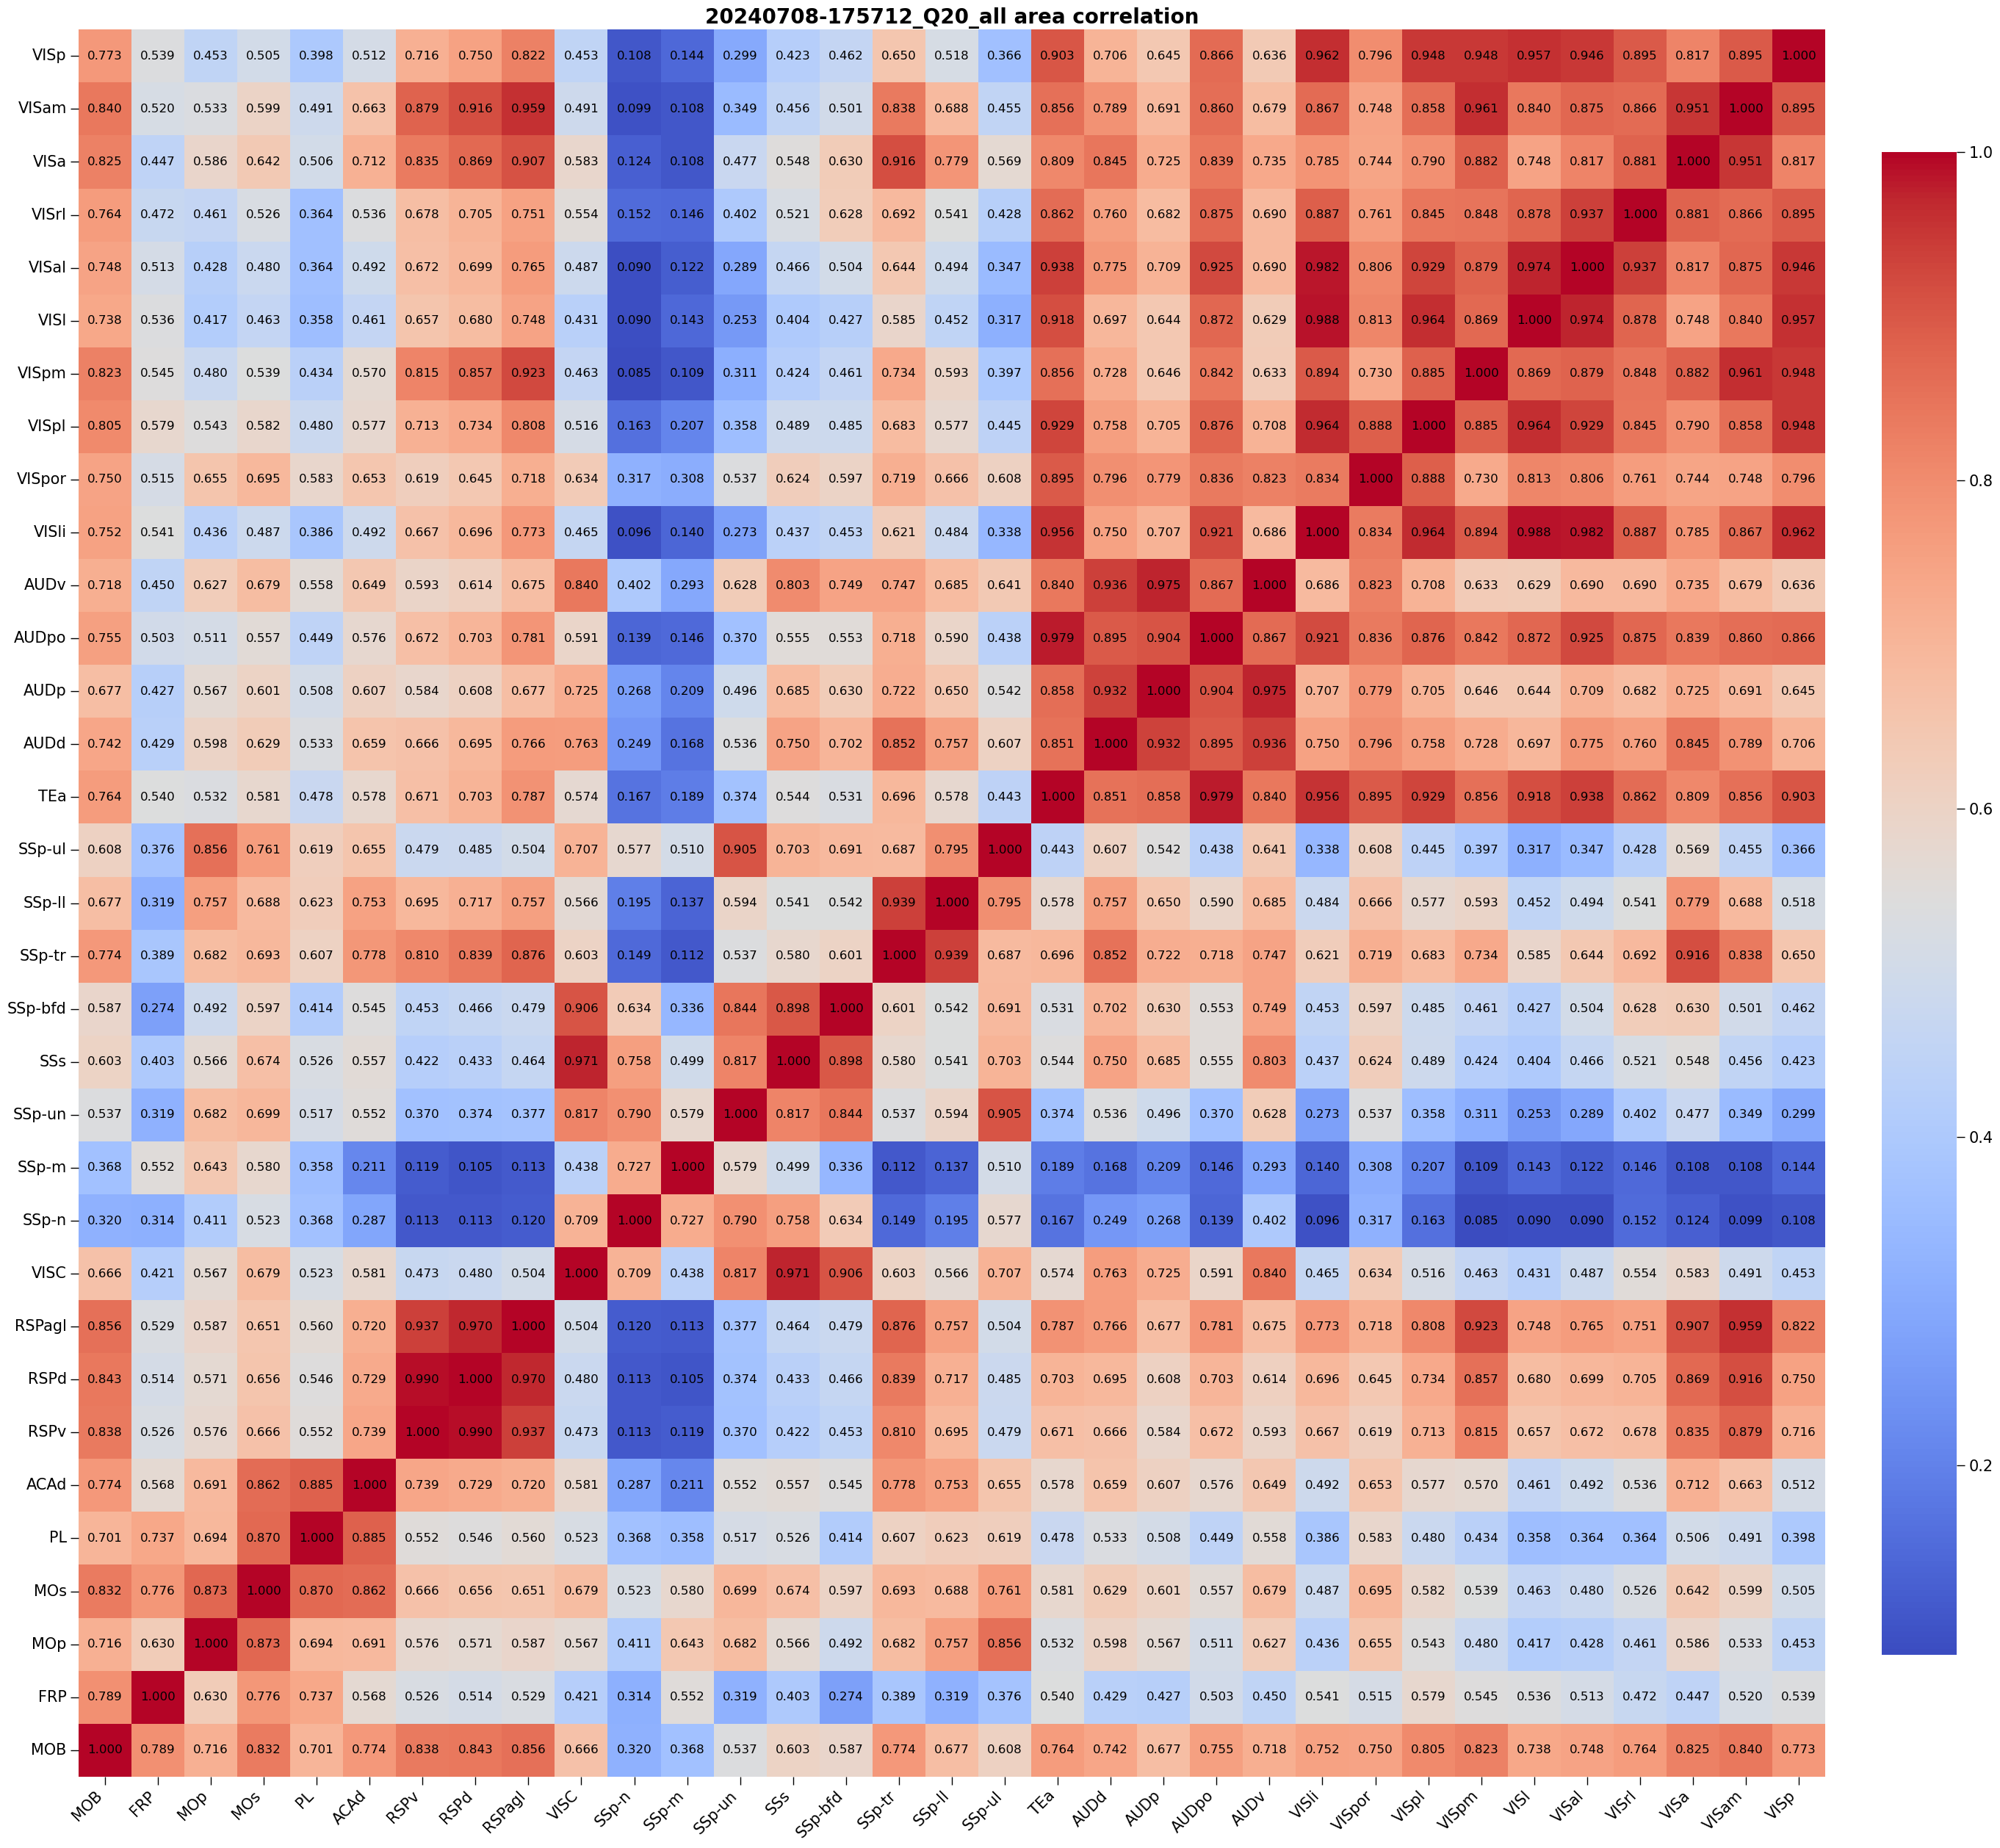

In [10]:
plot_heatmap(area_corr, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None, title=f'{experiment}_{mouse}_all area correlation', 
             outfile=pjoin(path_out,f'{experiment}_{mouse}_all area correlation.png'), dpi=300, annot=True)

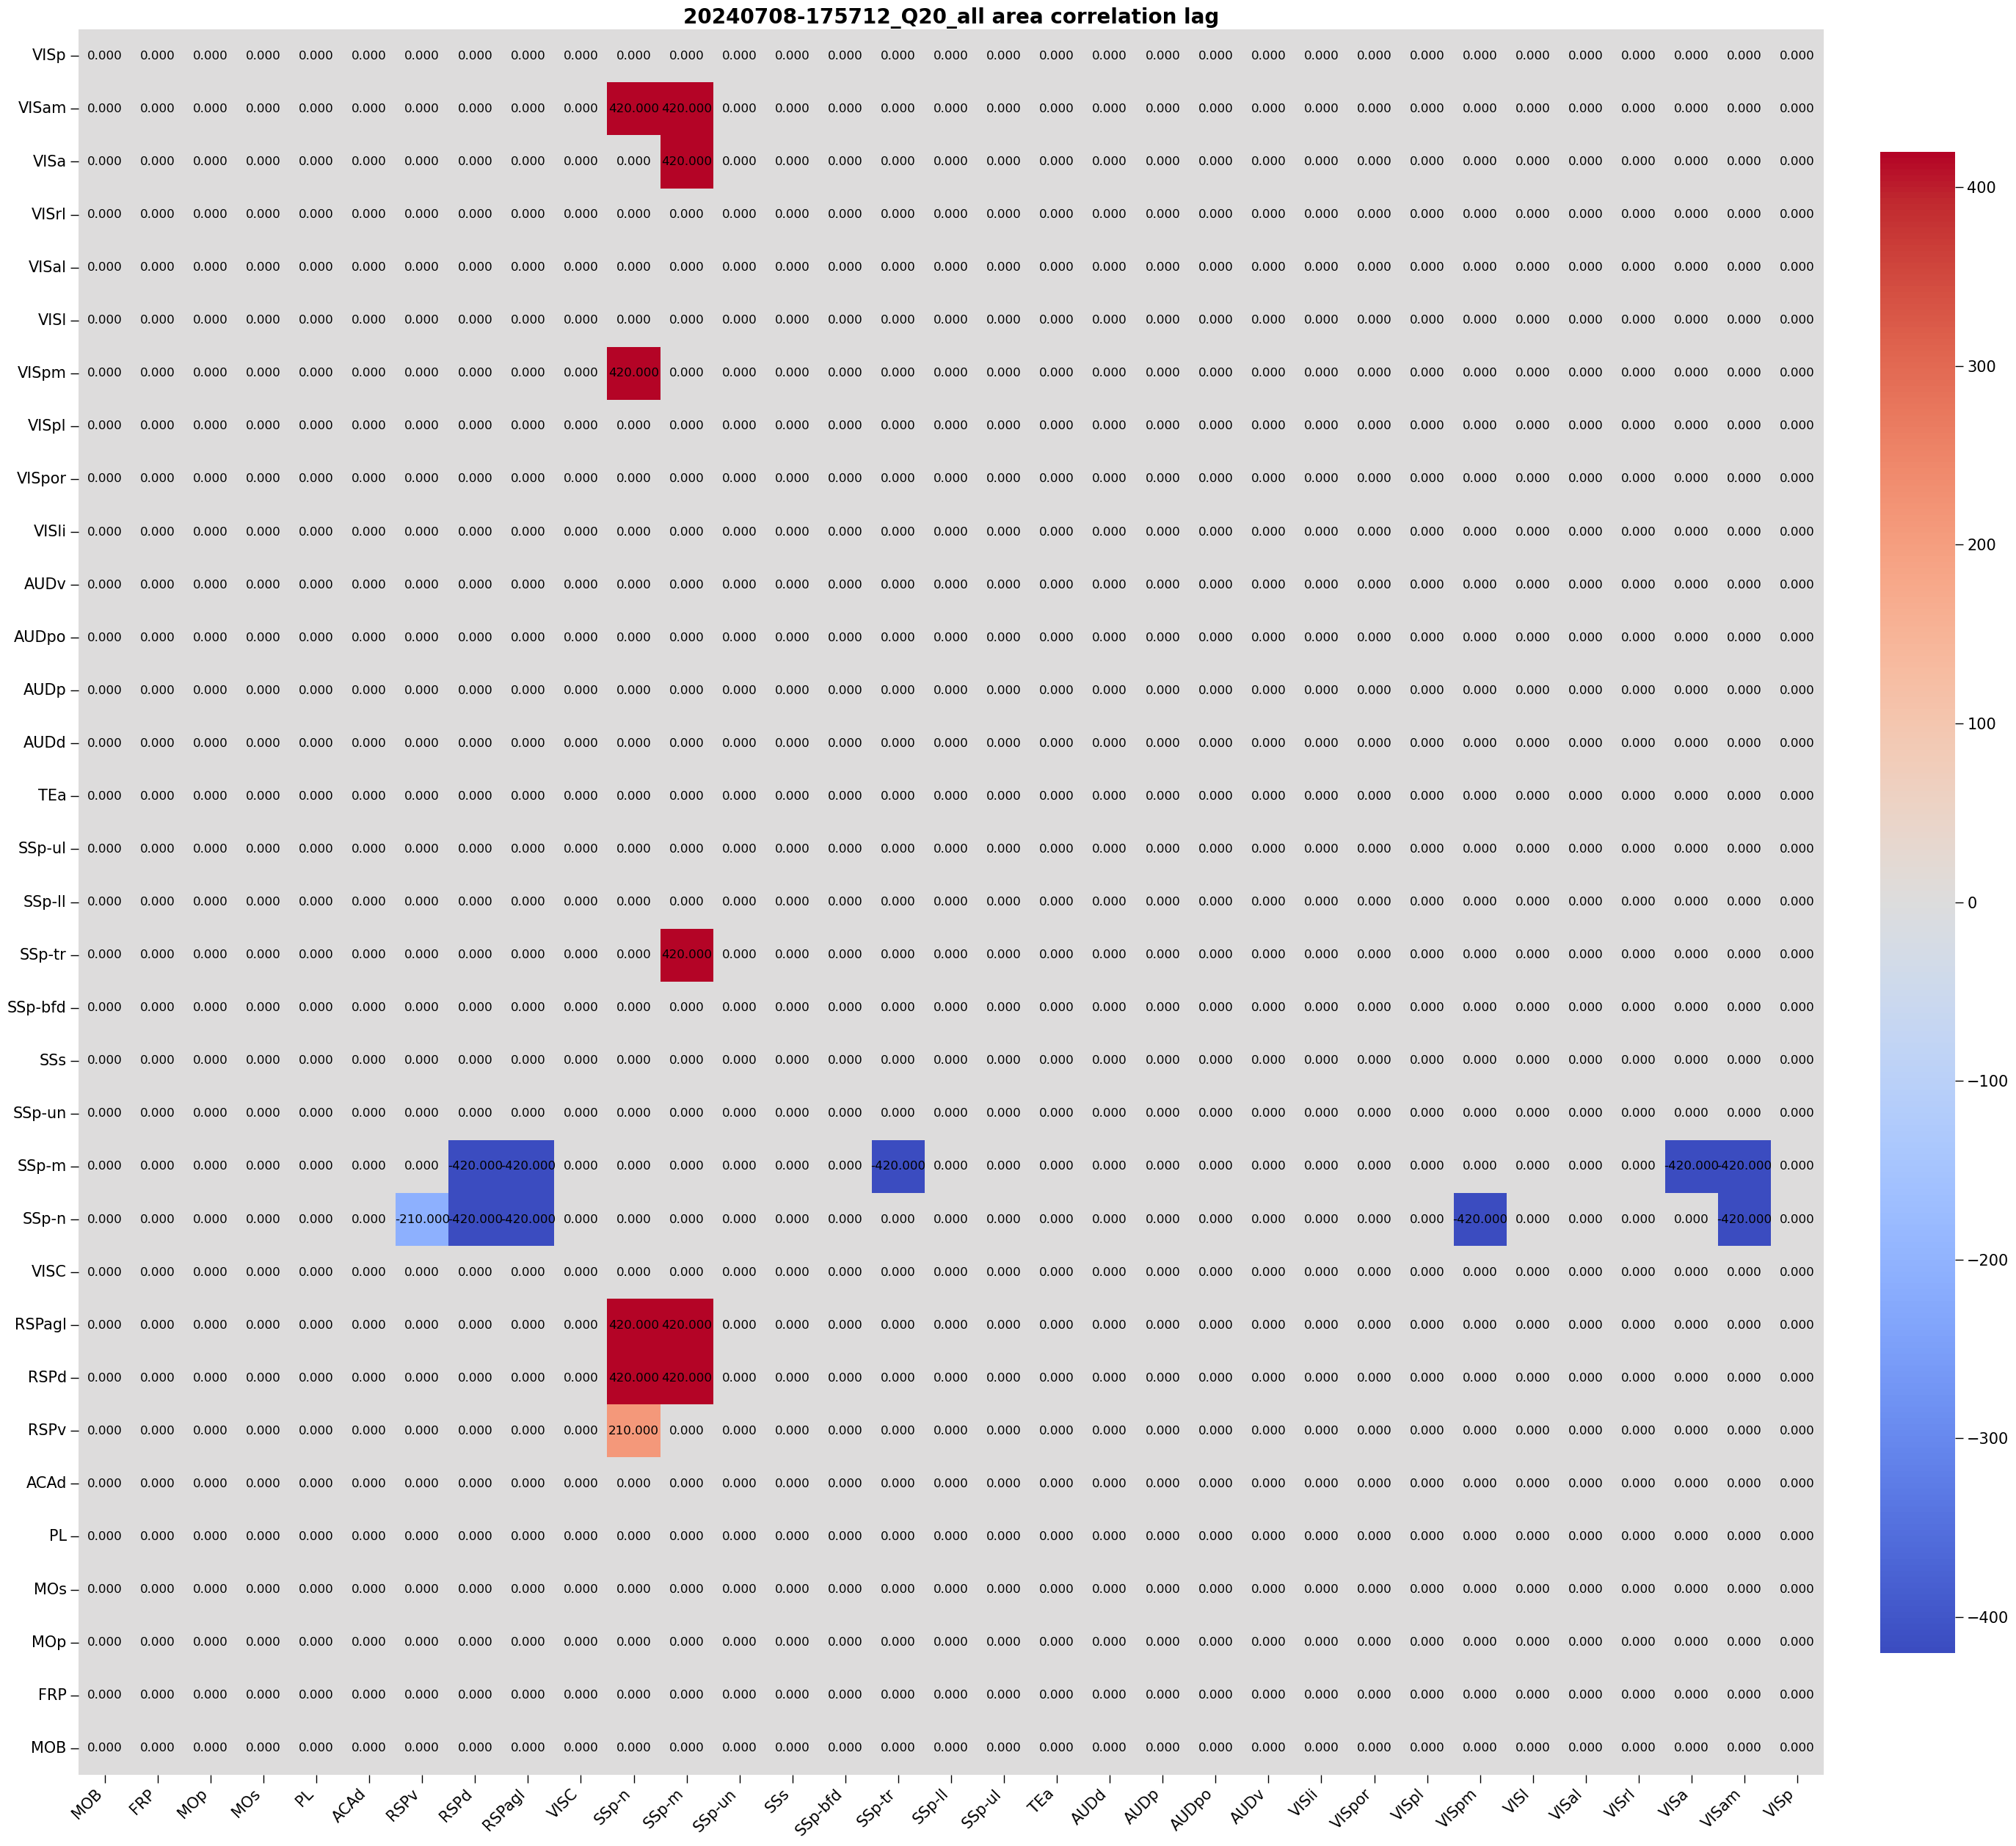

In [11]:
plot_heatmap(area_lag, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None, title=f'{experiment}_{mouse}_all area correlation lag', 
             outfile=pjoin(path_out,f'{experiment}_{mouse}_all area correlation lag.png'), dpi=300, annot=True)

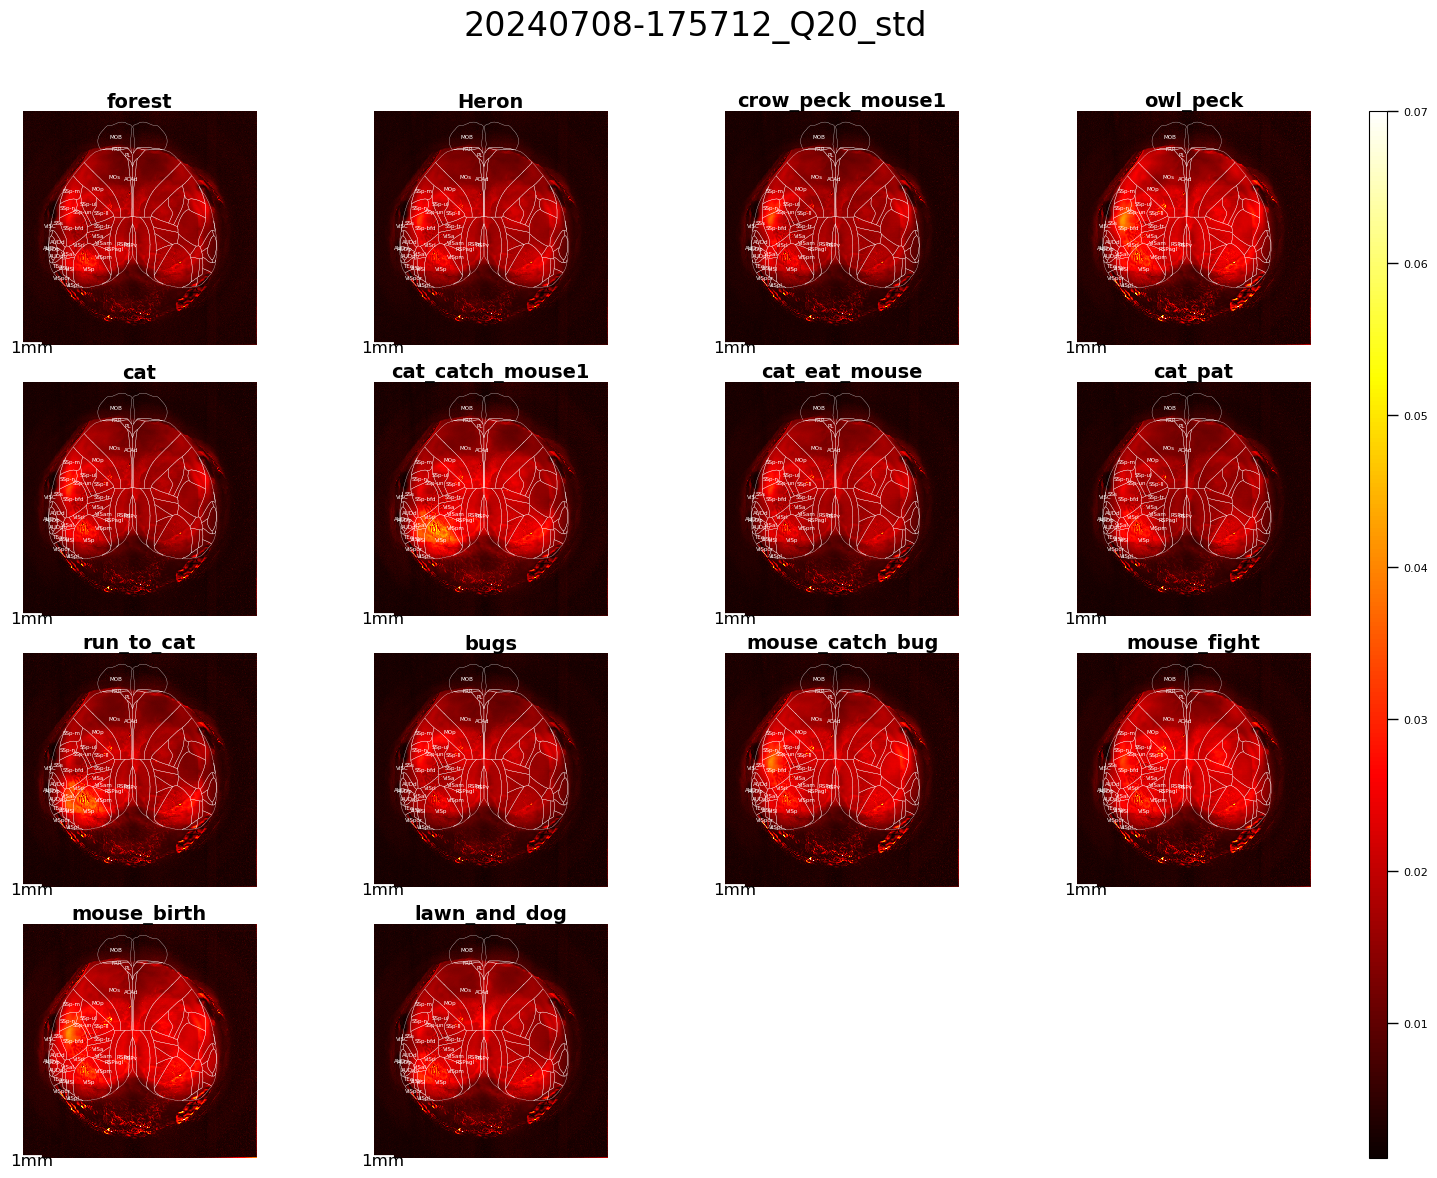

In [10]:
# std=np.std(cp.asnumpy(tif_sort), axis=(2,4))
# np.save(pjoin(path_out, 'std.npy'), std)

subplot_movie_heatmap(std, 4, 4, movie_name_list, path_outfile=pjoin(path_out, f'{experiment}_{mouse}_std.png'),
                      title=f'{experiment}_{mouse}_std', vmax=0.07, pixel_um=26, patches=None,
                      ccf_regions=ccf_regions_im)

